In [1]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import signal
from scipy import ndimage
from math import ceil
import cv2
import ot
import itertools

PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# PROJECT_PATH = os.getcwd()
sys.path.append(os.path.dirname(PROJECT_PATH))

from _prototypes.cell_remapping.src.remapping import pot_sliced_wasserstein
from _prototypes.cell_remapping.src.wasserstein_distance import _get_ratemap_bucket_midpoints
from library.map_utils import _temp_occupancy_map, _temp_spike_map, _speed2D, _speed_bins, _interpolate_matrix
from core.spatial import Position2D

unit_matcher_path = os.getcwd()
prototype_path = os.path.abspath(os.path.join(unit_matcher_path, os.pardir))
project_path = os.path.abspath(os.path.join(prototype_path, os.pardir))
lab_path = os.path.abspath(os.path.join(project_path, os.pardir))
sys.path.append(project_path)
os.chdir(project_path)
print(project_path)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\_prototypes


In [3]:
from x_io.rw.axona.batch_read import make_study
from _prototypes.cell_remapping.src.settings import settings_dict


In [4]:
# MEC path

project_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\LC_RAD"

studies = []
study_folders = []

for folder in os.listdir(project_path):
    settings_dict['smoothing_factor'] = 3
    settings_dict['ppm'] = 511
    settings_dict['useMatchedCut'] = True

    project_path_use = os.path.join(project_path,folder)
    study = make_study(project_path_use,settings_dict)
    study.make_animals()
    studies.append(study)
    study_folders.append(folder)

1 1
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\LC_RAD\sub/L-11242021-mAPPKI-PHF-1uL-HPC-1000um-900s-Rectangle-No-Object-Session-1-TINT_1_matched.cut
USING PPM YOU SET IN SETTINGS
PPM HERE:  511
Session animal ID set: sub_tet1
2 2
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\LC_RAD\sub/L-11242021-mAPPKI-PHF-1uL-HPC-1000um-900s-Rectangle-No-Object-Session-1-TINT_2_matched.cut
USING PPM YOU SET IN SETTINGS
PPM HERE:  511
Session animal ID set: sub_tet2
3 3
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\LC_RAD\sub/L-11242021-mAPPKI-PHF-1uL-HPC-1000um-900s-Rectangle-No-Object-Session-1-TINT_3_matched.cut
USING PPM YOU SET IN SETTINGS
PPM HERE:  511
Session animal ID set: sub_tet3
4 4
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\LC_RAD\sub/

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\library\spike\sort_spikes_by_cell.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  good_cells = np.asarray(cells)[idx]
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\library\spike\sort_spikes_by_cell.py:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  good_sorted_waveforms = np.asarray(sorted_waveforms)[idx]


NEW LABEL
Label:  1 idx:  2392
Label:  1 idx:  2392
Label:  1 spks:  2392
NEW LABEL
Label:  2 idx:  11912
Label:  2 idx:  11912
Label:  2 spks:  11912
NEW LABEL
Label:  3 idx:  16904
Label:  3 idx:  16904
Label:  3 spks:  16904
NEW LABEL
Label:  4 idx:  10860
Label:  4 idx:  10860
Label:  4 spks:  10860
NEW LABEL
Label:  5 idx:  4231
Label:  5 idx:  4231
Label:  5 spks:  4231
NEW LABEL
Label:  6 idx:  12083
Label:  6 idx:  12083
Label:  6 spks:  12083
Using matched cut files
6 6 6 6 [1 2 3 4 5 6] (array([0, 1, 2, 3, 4, 5], dtype=int64),) 7
[1 2 3 4 5 6] 6 6 6
Session data added, spikes sorted by cell
Total spikes:  86831
Matching labels is None T/F:  False
Unique labels:  [1 2 4 5 6]
NEW LABEL
Label:  1 idx:  18693
Label:  1 idx:  18693
Label:  1 spks:  18693
NEW LABEL
Label:  2 idx:  39813
Label:  2 idx:  39813
Label:  2 spks:  39813
NEW LABEL
Label:  4 idx:  10272
Label:  4 idx:  10272
Label:  4 spks:  10272
NEW LABEL
Label:  5 idx:  15457
Label:  5 idx:  15457
Label:  5 spks:  15457

In [5]:
# studies[0].animals[0].sessions['session_1'].get_spike_data()['spike_cluster'].get_unique_cluster_labels()
studies[0].animals[0].sessions.keys()

dict_keys(['session_1', 'session_2', 'session_3'])

In [6]:
from _prototypes.cell_remapping.src.masks import make_object_ratemap, check_disk_arena, flat_disk_mask, generate_grid, _sample_grid
from library.hafting_spatial_maps import SpatialSpikeTrain2D
from library.maps import map_blobs
from library.scores import hd_score, grid_score, border_score
from library.scores import rate_map_stats, rate_map_coherence, speed_score
import scipy as sio

def scale_points(pts):
    # Separate the x and y coordinates
    curr_spike_pos_x = pts[:, 0]
    curr_spike_pos_y = pts[:, 1]

    # Compute the minimum and maximum values for x and y coordinates
    min_x = np.min(curr_spike_pos_x)
    max_x = np.max(curr_spike_pos_x)
    min_y = np.min(curr_spike_pos_y)
    max_y = np.max(curr_spike_pos_y)

    # Perform Min-Max scaling separately for x and y coordinates
    scaled_x = (curr_spike_pos_x - min_x) / (max_x - min_x)
    scaled_y = (curr_spike_pos_y - min_y) / (max_y - min_y)

    # Combine the scaled x and y coordinates
    scaled_pts = np.column_stack((scaled_x, scaled_y))

    return scaled_pts

cell_dict = {}
blobs_cell_dict = {}
scores_cell_dict = {}
func_scores_dict = {}

for study in studies:
    for animal in study.animals:
        try:
            max_matched_cell_count = max(list(map(lambda x: max(animal.sessions[x].get_cell_data()['cell_ensemble'].get_label_ids()), animal.sessions)))
        except:
            max_matched_cell_count = 0
            for x in animal.sessions:
                cell_label_ids = animal.sessions[x].get_cell_data()['cell_ensemble'].get_label_ids() 
                nmb_matched = len(cell_label_ids)
                if nmb_matched > max_matched_cell_count:
                    max_matched_cell_count = nmb_matched
        for k in range(int(max_matched_cell_count)):
            cell_label = k + 1
            prev = None
            for i in range(len(list(animal.sessions.keys()))):
                seskey = 'session_' + str(i+1)
                ses = animal.sessions[seskey]
                path = ses.session_metadata.file_paths['tet']
                fname = path.split('/')[-1].split('.')[0]
                ensemble = animal.sessions[seskey].get_cell_data()['cell_ensemble']

                if cell_label in ensemble.get_cell_label_dict():
                    cell = ensemble.get_cell_by_id(cell_label)
                    
                    pos_obj = ses.get_position_data()['position']
                    spatial_spike_train = ses.make_class(SpatialSpikeTrain2D, {'cell': cell, 'position': pos_obj})

                    rate_map_obj = spatial_spike_train.get_map('rate')

                    rate_map, _ = rate_map_obj.get_rate_map(new_size = 32)

                    if 'cylinder' in fname.lower():
                        cylinder = True
                    else:
                        cylinder = False

                    image, n_labels, labels, centroids, field_sizes = map_blobs(spatial_spike_train, ratemap_size=32, cylinder=cylinder, 
                                                                                downsample=False, downsample_factor=None)
                    
                    # Disk mask ratemap
                    if cylinder:
                        non_flat_curr = np.copy(rate_map)
                        curr = flat_disk_mask(rate_map)
                        # curr[curr != curr] = 0
                        curr_ratemap = curr
                        row, col = np.where(~np.isnan(curr_ratemap))
                        disk_ids = np.array([row, col]).T
                    else:
                        curr = rate_map
                        curr_ratemap = curr
                        disk_ids = None

                    # plt.imshow(curr_ratemap, cmap='jet')
                    # plt.title(fname + ' ' + str(cell_label) + ' ' + seskey)
                    # plt.show()
                    # stop()
                    gscore = grid_score(spatial_spike_train)
                    bscore = border_score(spatial_spike_train)
                    ratemap_stats_dict = rate_map_stats(spatial_spike_train)
                    si_score = ratemap_stats_dict['spatial_information_content']
                    if prev is not None:
                        prev_ratemap = prev
                        curr_spatial_spike_train = spatial_spike_train
                        y, x = prev_ratemap.shape
                        # prev_spike_pos_x, prev_spike_pos_y, prev_spike_pos_t = prev_spatial_spike_train.spike_x, prev_spatial_spike_train.spike_y, prev_spatial_spike_train.new_spike_times
                        # prev_pts = np.array([prev_spike_pos_x, prev_spike_pos_y])
                        # curr_spike_pos_x, curr_spike_pos_y, curr_spike_pos_t = curr_spatial_spike_train.spike_x, curr_spatial_spike_train.spike_y, curr_spatial_spike_train.new_spike_times
                        # curr_pts = np.array([curr_spike_pos_x, curr_spike_pos_y]).T
                        # find indices of not nan 
                        row_prev, col_prev = np.where(~np.isnan(prev_ratemap))
                        row_curr, col_curr = np.where(~np.isnan(curr_ratemap))

                        prev_height_bucket_midpoints, prev_width_bucket_midpoints = _get_ratemap_bucket_midpoints(prev_spatial_spike_train.arena_size, y, x)
                        curr_height_bucket_midpoints, curr_width_bucket_midpoints = _get_ratemap_bucket_midpoints(curr_spatial_spike_train.arena_size, y, x)
                                    
                        prev_height_bucket_midpoints = prev_height_bucket_midpoints[row_prev]
                        prev_width_bucket_midpoints = prev_width_bucket_midpoints[col_prev]
                        curr_height_bucket_midpoints = curr_height_bucket_midpoints[row_curr]
                        curr_width_bucket_midpoints = curr_width_bucket_midpoints[col_curr]
                        source_weights = np.array(list(map(lambda x, y: prev_ratemap[x,y], row_prev, col_prev)))
                        target_weights = np.array(list(map(lambda x, y: curr_ratemap[x,y], row_curr, col_curr)))
                        if np.sum(source_weights) != 0:
                            source_weights = source_weights / np.sum(source_weights)
                        if np.sum(target_weights) != 0:
                            target_weights = target_weights / np.sum(target_weights)
                        coord_buckets_curr = np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_curr, col_curr)))
                        coord_buckets_prev = np.array(list(map(lambda x, y: [prev_height_bucket_midpoints[x],prev_width_bucket_midpoints[y]], row_prev, col_prev)))

                        # curr_pts = scale_points(curr_pts)
                        # prev_pts = scale_points(prev_pts)
                        # spike_dens_wass = pot_sliced_wasserstein(prev_pts, curr_pts, n_projections=10**3)
                        wass = pot_sliced_wasserstein(coord_buckets_prev, coord_buckets_curr, source_weights, target_weights, n_projections=10**3)
                        
                        # if len(source_weights) != len(target_weights):
                            # row_use = np.argmin([len(source_weights), len(target_weights)])
                            # row_use = [row_prev, row_curr][row_use]
                            # col_use = np.argmin([len(source_weights), len(target_weights)])
                            # col_use = [col_prev, col_curr][col_use]
                        row_not_nan_source = np.where(~np.isnan(prev_ratemap))[0]
                        row_not_nan_target = np.where(~np.isnan(curr_ratemap))[0]
                        col_not_nan_source = np.where(~np.isnan(prev_ratemap))[1]
                        col_not_nan_target = np.where(~np.isnan(curr_ratemap))[1]
                        row_col_not_nan_source = np.array(list(zip(row_not_nan_source, col_not_nan_source)))
                        row_col_not_nan_target = np.array(list(zip(row_not_nan_target, col_not_nan_target)))
                        row_col_use = list(set(map(tuple, row_col_not_nan_source)).intersection(map(tuple, row_col_not_nan_target)))
                        row_use = [x[0] for x in row_col_use]
                        col_use = [x[1] for x in row_col_use]                        
                        source_weights = np.array(list(map(lambda x, y: prev_ratemap[x,y], row_use, col_use)))
                        target_weights = np.array(list(map(lambda x, y: curr_ratemap[x,y], row_use, col_use)))
                        if np.sum(source_weights) != 0:
                            source_weights = source_weights / np.sum(source_weights)
                        if np.sum(target_weights) != 0:
                            target_weights = target_weights / np.sum(target_weights)

                        corr = pearsonr(source_weights, target_weights)[0]

                        wass_shifts = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        wass_shifts[:] = np.nan
                        corr_shifts = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        corr_shifts[:] = np.nan
                        wass_shifts_wrap = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        wass_shifts_wrap[:] = np.nan
                        corr_shifts_wrap = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        corr_shifts_wrap[:] = np.nan
                        wass_shifts_center = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        wass_shifts_center[:] = np.nan
                        corr_shifts_center = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        corr_shifts_center[:] = np.nan
                        wass_shifts_center_wrap = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        wass_shifts_center_wrap[:] = np.nan
                        corr_shifts_center_wrap = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        corr_shifts_center_wrap[:] = np.nan
                        print('looping')
                        for i in range(prev_ratemap.shape[0]):
                            for j in range(prev_ratemap.shape[1]):
                                # if disk_ids is not None and [i,j] in disk_ids.tolist():
                                if True:
                                    
                                    shift = (i, j)
                                    shift_center = (i - int(np.floor(prev_ratemap.shape[0] / 2)), j - int(np.floor(prev_ratemap.shape[1] / 2)))
                                    
                                    if cylinder:
                                        wrap_map = np.roll(non_flat_curr, shift=shift, axis=(0, 1))
                                        wrap_map = flat_disk_mask(wrap_map)
                                        # wrap_map[wrap_map != wrap_map] = 0
                                        wrap_map_center = np.roll(non_flat_curr, shift=shift_center, axis=(0, 1)) 
                                        wrap_map_center = flat_disk_mask(wrap_map_center)

                                        # wrap_map_center[wrap_map_center != wrap_map_center] = 0
                                        shifted_map = flat_disk_mask(non_flat_curr)
                                        shifted_map[shifted_map != shifted_map] = 0
                                        shifted_map = sio.ndimage.shift(shifted_map, shift, mode='constant', cval=0)
                                        # shifted_map[shifted_map < 0.01] = np.nan
                                        shifted_map = flat_disk_mask(shifted_map)

                                        # shifted_map[shifted_map != shifted_map] = 0
                                        shifted_map_center = flat_disk_mask(non_flat_curr)
                                        shifted_map_center[shifted_map_center != shifted_map_center] = 0
                                        shifted_map_center = sio.ndimage.shift(shifted_map_center, shift_center, mode='constant', cval=0)
                                        # shifted_map_center[shifted_map_center < 0.01] = np.nan
                                        # shifted_map_center[shifted_map_center != shifted_map_center] = 0
                                        shifted_map_center = flat_disk_mask(shifted_map_center)

                                    else:
                                        wrap_map = np.roll(curr_ratemap, shift=shift, axis=(0, 1))
                                        wrap_map_center = np.roll(curr_ratemap, shift=shift_center, axis=(0, 1))
                                        shifted_map = sio.ndimage.shift(curr_ratemap, shift, mode='constant', cval=0)
                                        shifted_map_center = sio.ndimage.shift(curr_ratemap, shift_center, mode='constant', cval=0)

                                    row_curr, col_curr = np.where(~np.isnan(shifted_map))
                                    row_prev, col_prev = np.where(~np.isnan(prev_ratemap))
                                    row_curr_center, col_curr_center = np.where(~np.isnan(shifted_map_center))
                                    row_curr_wrap, col_curr_wrap = np.where(~np.isnan(wrap_map))
                                    row_curr_center_wrap, col_curr_center_wrap = np.where(~np.isnan(wrap_map_center))
                                    prev_height_bucket_midpoints, prev_width_bucket_midpoints = _get_ratemap_bucket_midpoints(prev_spatial_spike_train.arena_size, y, x)
                                    curr_height_bucket_midpoints, curr_width_bucket_midpoints = _get_ratemap_bucket_midpoints(curr_spatial_spike_train.arena_size, y, x)
                                    # curr_height_bucket_midpoints = curr_height_bucket_midpoints[row_curr]
                                    # curr_width_bucket_midpoints = curr_width_bucket_midpoints[col_curr]
                                    target_weights = np.array(list(map(lambda x, y: shifted_map[x,y], row_curr, col_curr)))
                                    source_weights = np.array(list(map(lambda x, y: prev_ratemap[x,y], row_prev, col_prev)))
                                    target_weights_wrap = np.array(list(map(lambda x, y: wrap_map[x,y], row_curr_wrap, col_curr_wrap)))
                                    target_weights_center = np.array(list(map(lambda x, y: shifted_map_center[x,y], row_curr_center, col_curr_center)))
                                    target_weights_wrap_center = np.array(list(map(lambda x, y: wrap_map_center[x,y], row_curr_center_wrap, col_curr_wrap)))
                                    # source_weights_pearson = np.array(list(map(lambda x, y: prev_ratemap[x,y], row_prev, col_prev)))
                                    if np.sum(source_weights) != 0:
                                        source_weights = source_weights / np.sum(source_weights)
                                    if np.sum(target_weights) != 0:
                                        target_weights = target_weights / np.sum(target_weights)
                                    if np.sum(target_weights_wrap) != 0:
                                        target_weights_wrap = target_weights_wrap / np.sum(target_weights_wrap)
                                    if np.sum(target_weights_center) != 0:
                                        target_weights_center = target_weights_center / np.sum(target_weights_center)
                                    if np.sum(target_weights_wrap_center) != 0:
                                        target_weights_wrap_center = target_weights_wrap_center / np.sum(target_weights_wrap_center)
                                    # source_weights_pearson = source_weights_pearson / np.sum(source_weights_pearson)

                                    coord_buckets_prev = np.array(list(map(lambda x, y: [prev_height_bucket_midpoints[x],prev_width_bucket_midpoints[y]], row_prev, col_prev)))
                                    coord_buckets_curr = np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_curr, col_curr)))
                                    coord_buckets_curr_wrap = np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_curr_wrap, col_curr_wrap)))
                                    coord_buckets_curr_center = np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_curr_center, col_curr_center)))
                                    coord_buckets_curr_center_wrap = np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_curr_center_wrap, col_curr_center_wrap)))

                                    wass_shift = pot_sliced_wasserstein(coord_buckets_prev, coord_buckets_curr, source_weights, target_weights, n_projections=10**3)
                                    wass_wrap = pot_sliced_wasserstein(coord_buckets_prev, coord_buckets_curr_wrap, source_weights, target_weights_wrap, n_projections=10**3)
                                    wass_shift_center = pot_sliced_wasserstein(coord_buckets_prev, coord_buckets_curr_center, source_weights, target_weights_center, n_projections=10**3)
                                    wass_wrap_center = pot_sliced_wasserstein(coord_buckets_prev, coord_buckets_curr_center_wrap, source_weights, target_weights_wrap_center, n_projections=10**3)

                                    # if len(source_weights) != len(target_weights):

                                    prev_ratemap = flat_disk_mask(prev_ratemap)
                                    shifted_map = flat_disk_mask(shifted_map)   
                                    row_not_nan_source = np.where(~np.isnan(prev_ratemap))[0]
                                    row_not_nan_target = np.where(~np.isnan(shifted_map))[0]
                                    col_not_nan_source = np.where(~np.isnan(prev_ratemap))[1]
                                    col_not_nan_target = np.where(~np.isnan(shifted_map))[1]
                                    row_col_not_nan_source = np.array(list(zip(row_not_nan_source, col_not_nan_source)))
                                    row_col_not_nan_target = np.array(list(zip(row_not_nan_target, col_not_nan_target)))
                                    row_col_use = list(set(map(tuple, row_col_not_nan_source)).intersection(map(tuple, row_col_not_nan_target)))
                                    row_use = [x[0] for x in row_col_use]
                                    col_use = [x[1] for x in row_col_use]                                   
                                    # row_use = np.argmin([len(source_weights), len(target_weights)])
                                    # row_use = [row_prev, row_curr][row_use]
                                    # col_use = np.argmin([len(source_weights), len(target_weights)])
                                    # col_use = [col_prev, col_curr][col_use]
                                    source_weights_pearson = np.array(list(map(lambda x, y: prev_ratemap[x,y], row_use, col_use)))
                                    target_weights_pearson = np.array(list(map(lambda x, y: shifted_map[x,y], row_use, col_use)))
                                    assert len(source_weights_pearson) == len(target_weights_pearson), 'source and target weights are not the same length'
                                    if np.sum(source_weights_pearson) != 0:
                                        source_weights_pearson = source_weights_pearson / np.sum(source_weights_pearson)
                                    if np.sum(target_weights_pearson) != 0: 
                                        target_weights_pearson = target_weights_pearson / np.sum(target_weights_pearson)
                                    coord_buckets_curr = np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_use, col_use)))
                                    coord_buckets_prev = np.array(list(map(lambda x, y: [prev_height_bucket_midpoints[x],prev_width_bucket_midpoints[y]], row_use, col_use)))                               
                                    assert len(source_weights_pearson[source_weights_pearson != source_weights_pearson]) == 0, 'source weights pearson contains {} nan values'.format(len(source_weights_pearson[source_weights_pearson != source_weights_pearson]))

                                    wrap_map = flat_disk_mask(wrap_map)
                                    row_not_nan_source = np.where(~np.isnan(prev_ratemap))[0]
                                    row_not_nan_target = np.where(~np.isnan(wrap_map))[0]
                                    col_not_nan_source = np.where(~np.isnan(prev_ratemap))[1]
                                    col_not_nan_target = np.where(~np.isnan(wrap_map))[1]
                                    row_col_not_nan_source = np.array(list(zip(row_not_nan_source, col_not_nan_source)))
                                    row_col_not_nan_target = np.array(list(zip(row_not_nan_target, col_not_nan_target)))
                                    row_col_use = list(set(map(tuple, row_col_not_nan_source)).intersection(map(tuple, row_col_not_nan_target)))
                                    row_use = [x[0] for x in row_col_use]
                                    col_use = [x[1] for x in row_col_use]

                                    target_weights_wrap_pearson = np.array(list(map(lambda x, y: wrap_map[x,y], row_use, col_use)))
                                    if np.sum(target_weights_wrap_pearson) != 0: 
                                        target_weights_wrap_pearson = target_weights_wrap_pearson / np.sum(target_weights_wrap_pearson)
                                    coord_buckets_curr_wrap = np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_use, col_use)))
                                    coord_buckets_prev_wrap = np.array(list(map(lambda x, y: [prev_height_bucket_midpoints[x],prev_width_bucket_midpoints[y]], row_use, col_use)))                               
                                    source_weights_wrap_pearson = np.array(list(map(lambda x, y: prev_ratemap[x,y], row_use, col_use)))
                                    assert len(source_weights_wrap_pearson[source_weights_wrap_pearson != source_weights_wrap_pearson]) == 0, 'source weights pearson contains {} nan values'.format(len(source_weights_pearson[source_weights_pearson != source_weights_pearson]))
                                    if np.sum(source_weights_wrap_pearson) != 0:
                                        source_weights_wrap_pearson = source_weights_wrap_pearson / np.sum(source_weights_wrap_pearson)
                                    
                                    shifted_map_center = flat_disk_mask(shifted_map_center)     
                                    row_not_nan_source = np.where(~np.isnan(prev_ratemap))[0]
                                    row_not_nan_target = np.where(~np.isnan(shifted_map_center))[0]
                                    col_not_nan_source = np.where(~np.isnan(prev_ratemap))[1]
                                    col_not_nan_target = np.where(~np.isnan(shifted_map_center))[1]
                                    row_col_not_nan_source = np.array(list(zip(row_not_nan_source, col_not_nan_source)))
                                    row_col_not_nan_target = np.array(list(zip(row_not_nan_target, col_not_nan_target)))
                                    row_col_use = list(set(map(tuple, row_col_not_nan_source)).intersection(map(tuple, row_col_not_nan_target)))
                                    row_use = [x[0] for x in row_col_use]
                                    col_use = [x[1] for x in row_col_use]
                                    
                                    target_weights_center_pearson = np.array(list(map(lambda x, y: shifted_map_center[x,y], row_use, col_use)))
                                    if np.sum(target_weights_center_pearson) != 0:
                                        target_weights_center_pearson = target_weights_center_pearson / np.sum(target_weights_center_pearson)
                                    coord_buckets_curr_center = np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_use, col_use)))
                                    coord_buckets_prev_center = np.array(list(map(lambda x, y: [prev_height_bucket_midpoints[x],prev_width_bucket_midpoints[y]], row_use, col_use)))
                                    source_weights_center_pearson = np.array(list(map(lambda x, y: prev_ratemap[x,y], row_use, col_use)))
                                    assert len(source_weights_center_pearson[source_weights_center_pearson != source_weights_center_pearson]) == 0, 'source weights pearson contains {} nan values'.format(len(source_weights_pearson[source_weights_pearson != source_weights_pearson]))
                                    if np.sum(source_weights_center_pearson) != 0:
                                        source_weights_center_pearson = source_weights_center_pearson / np.sum(source_weights_center_pearson)

                                    wrap_map_center = flat_disk_mask(wrap_map_center)
                                    row_not_nan_source = np.where(~np.isnan(prev_ratemap))[0]
                                    row_not_nan_target = np.where(~np.isnan(wrap_map_center))[0]
                                    col_not_nan_source = np.where(~np.isnan(prev_ratemap))[1]
                                    col_not_nan_target = np.where(~np.isnan(wrap_map_center))[1]
                                    row_col_not_nan_source = np.array(list(zip(row_not_nan_source, col_not_nan_source)))
                                    row_col_not_nan_target = np.array(list(zip(row_not_nan_target, col_not_nan_target)))
                                    row_col_use = list(set(map(tuple, row_col_not_nan_source)).intersection(map(tuple, row_col_not_nan_target)))
                                    row_use = [x[0] for x in row_col_use]
                                    col_use = [x[1] for x in row_col_use]

                                    target_weights_wrap_center_pearson = np.array(list(map(lambda x, y: wrap_map_center[x,y], row_use, col_use)))
                                    if np.sum(target_weights_wrap_center_pearson) != 0:
                                        target_weights_wrap_center_pearson = target_weights_wrap_center_pearson / np.sum(target_weights_wrap_center_pearson)
                                    coord_buckets_curr_center_wrap = np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_use, col_use)))
                                    coord_buckets_prev_center_wrap = np.array(list(map(lambda x, y: [prev_height_bucket_midpoints[x],prev_width_bucket_midpoints[y]], row_use, col_use)))
                                    source_weights_wrap_center_pearson = np.array(list(map(lambda x, y: prev_ratemap[x,y], row_use, col_use)))
                                    assert len(source_weights_wrap_center_pearson[source_weights_wrap_center_pearson != source_weights_wrap_center_pearson]) == 0,'source weights pearson contains {} nan values'.format(len(source_weights_pearson[source_weights_pearson != source_weights_pearson]))
                                    if np.sum(source_weights_wrap_center_pearson) != 0:
                                        source_weights_wrap_center_pearson = source_weights_wrap_center_pearson / np.sum(source_weights_wrap_center_pearson)

                                    try:
                                        corr_shift = pearsonr(source_weights_pearson, target_weights_pearson)[0]
                                    except:
                                        corr_shift = np.nan
                                    try:
                                        corr_wrap = pearsonr(source_weights_wrap_pearson, target_weights_wrap_pearson)[0]
                                    except:
                                        corr_wrap = np.nan
                                    try:
                                        corr_shift_center = pearsonr(source_weights_center_pearson, target_weights_center_pearson)[0]
                                    except:
                                        corr_shift_center = np.nan
                                    try:
                                        corr_wrap_center = pearsonr(source_weights_wrap_center_pearson, target_weights_wrap_center_pearson)[0]
                                    except:
                                        corr_wrap_center = np.nan
                                        
                                    wass_shifts[i, j] = wass_shift
                                    corr_shifts[i, j] = corr_shift
                                    wass_shifts_wrap[i, j] = wass_wrap
                                    corr_shifts_wrap[i, j] = corr_wrap
                                    wass_shifts_center[i, j] = wass_shift_center
                                    corr_shifts_center[i, j] = corr_shift_center
                                    wass_shifts_center_wrap[i, j] = wass_wrap_center
                                    corr_shifts_center_wrap[i, j] = corr_wrap_center
    
                                    # corr_shifts_center_wrap[shift_center[0], shift_center[1]] = corr_wrap_center
                                
                    title = animal.animal_id + '_' + seskey.replace('_', '') + '_' + str(cell_label)

                    cell_dict[title] = curr_ratemap
                    blobs_cell_dict[title] = [labels, centroids]
                    if prev is not None:
                        scores_cell_dict[title] = [wass, corr, wass_shifts, corr_shifts, wass_shifts_wrap, corr_shifts_wrap,
                                                    wass_shifts_center, corr_shifts_center, wass_shifts_center_wrap, corr_shifts_center_wrap]

                    func_scores_dict[title] = [gscore, bscore, si_score]

                    prev = curr_ratemap
                    prev_spatial_spike_train = spatial_spike_train

                

Using speed bounds 0 to 100
computing rate map bcs map_data is None
getting occ map
getting spike map
Computing rate map
using existing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 32


c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\library\hafting_spatial_maps.py:573: RuntimeWarning: divide by zero encountered in divide
  rate_map_raw = np.where(raw_occ<0.0001, 0, spike_map_data_raw/raw_occ)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\library\hafting_spatial_maps.py:573: RuntimeWarning: invalid value encountered in divide
  rate_map_raw = np.where(raw_occ<0.0001, 0, spike_map_data_raw/raw_occ)


Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
Using speed bounds 0 to 100
computing rate map bcs map_data is None
getting occ map
getting spike map
Computing rate map
using existing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 32
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
looping


c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Using speed bounds 0 to 100
computing rate map bcs map_data is None
getting occ map
getting spike map
Computing rate map
using existing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 32
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
Using speed bounds 0 to 100
computing rate map bcs map_data is None
getting occ map
getting spike map
Computing rate map
using existing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 32
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_siz

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\library\spatial\fit_ellipse.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  tv_centre = -Av / (2*Avv)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\library\spatial\fit_ellipse.py:143: RuntimeWarning: invalid value encountered in double_scalars
  w_centre = Ao - (Auu*tu_centre*tu_centre) - (Avv*tv_centre*tv_centre)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\library\spatial\fit_ellipse.py:145: RuntimeWarning: invalid value encountered in double_scalars
  x_centre = (tu_centre * cos_t) - (tv_centre * sin_t)


computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
Using speed bounds 0 to 100
computing rate map bcs map_data is None
getting occ map
getting spike map
Computing rate map
using existing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 32
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
looping
Using speed bounds 0 to 100
computing rate map bcs map_data is None
getting occ map
getting spike map
Computing rate map
using existing rate map
computing rate map bcs

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\library\scores\grid_score.py:474: RuntimeWarning: Mean of empty slice
  'grid_spacing': np.nanmean(gs_spacings),


Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
looping


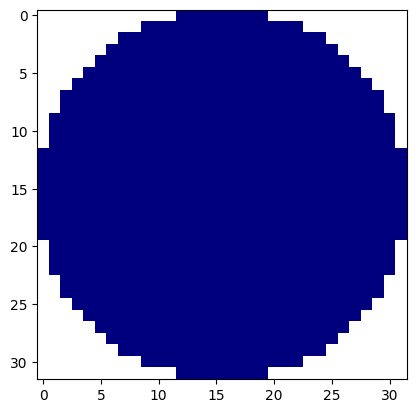

In [7]:
# wass_wrap_center = pot_sliced_wasserstein(coord_buckets_prev, coord_buckets_curr_center_wrap, source_weights, target_weights_wrap_center, n_projections=10**3)
plt.imshow(flat_disk_mask(shifted_map), cmap='jet')

In [8]:
row_not_nan_source = np.where(~np.isnan(prev_ratemap))[0]
row_not_nan_target = np.where(~np.isnan(curr_ratemap))[0]
col_not_nan_source = np.where(~np.isnan(prev_ratemap))[1]
col_not_nan_target = np.where(~np.isnan(curr_ratemap))[1]
row_col_not_nan_source = np.array(list(zip(row_not_nan_source, col_not_nan_source)))
row_col_not_nan_target = np.array(list(zip(row_not_nan_target, col_not_nan_target)))
row_col_use = list(set(map(tuple, row_col_not_nan_source)).intersection(map(tuple, row_col_not_nan_target)))
row_use = [x[0] for x in row_col_use]
col_use = [x[1] for x in row_col_use]
print(len(row_not_nan_source), len(row_not_nan_target), len(row_use))
print(len(col_not_nan_source), len(col_not_nan_target), len(col_use))

812 1024 812
812 1024 812


C:\Users\aaoun\AppData\Local\Temp\ipykernel_26356\893585039.py:1: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(prev_ratemap[row_use[0]:row_use[-1], col_use[0]:col_use[-1]], cmap='jet')
C:\Users\aaoun\AppData\Local\Temp\ipykernel_26356\893585039.py:1: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(prev_ratemap[row_use[0]:row_use[-1], col_use[0]:col_use[-1]], cmap='jet')


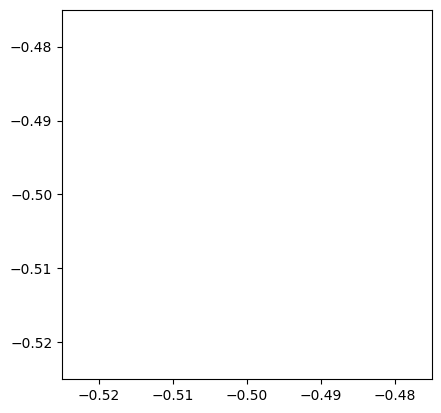

In [9]:
plt.imshow(prev_ratemap[row_use[0]:row_use[-1], col_use[0]:col_use[-1]], cmap='jet')

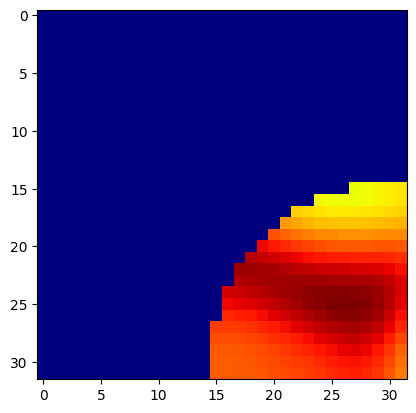

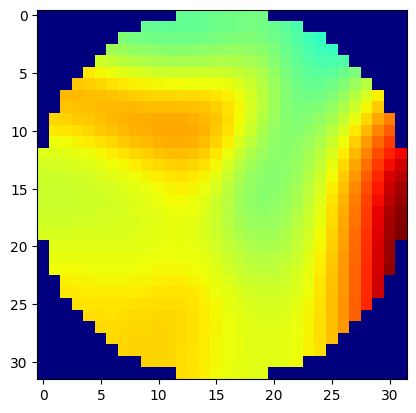

In [10]:
                                        # shifted_map = flat_disk_mask(non_flat_curr)
                                        # shifted_map = sio.ndimage.shift(shifted_map, shift, mode='constant', cval=0)
                                        # shifted_map[shifted_map < 0.01] = np.nan
copied = np.copy(prev_ratemap)
copied2 = np.copy(prev_ratemap)
copied2[copied2 != copied2] = 0
copied[copied != copied] = 0
copied = sio.ndimage.shift(copied, (15,15), mode='constant', cval=0)
# copied[copied < 0.01] = np.nan
plt.imshow(copied, cmap='jet')
plt.show()
plt.imshow(copied2, cmap='jet')
plt.show()

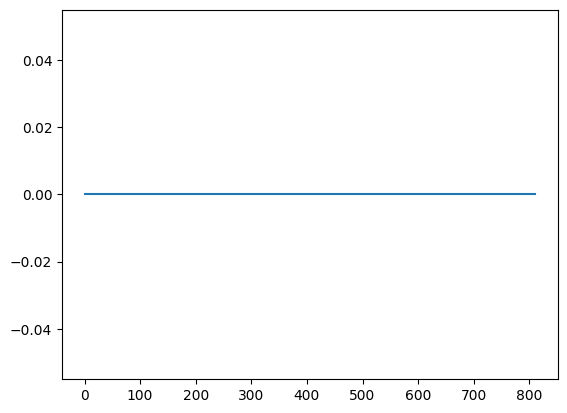

In [11]:
plt.plot(target_weights_pearson)

In [12]:
plt.imshow(targ)

NameError: name 'targ' is not defined

In [ ]:
target_weights = np.array(list(map(lambda x, y: curr_ratemap[x,y], row_curr, col_curr)))
target_weights = target_weights / np.sum(target_weights)
print(target_weights)


In [ ]:
plt.imshow(shifted_map)

In [13]:
grouped_sessions = {}
for key in cell_dict.keys():
    parts = key.split('_')
    tetrode = parts[1].split('tet')[-1]    
    unit = parts[-1]  
    unit_tetrode_key = f'sub_tet{tetrode}_unit{unit}' 
    if unit_tetrode_key not in grouped_sessions:
        grouped_sessions[unit_tetrode_key] = []
    grouped_sessions[unit_tetrode_key].append(key)

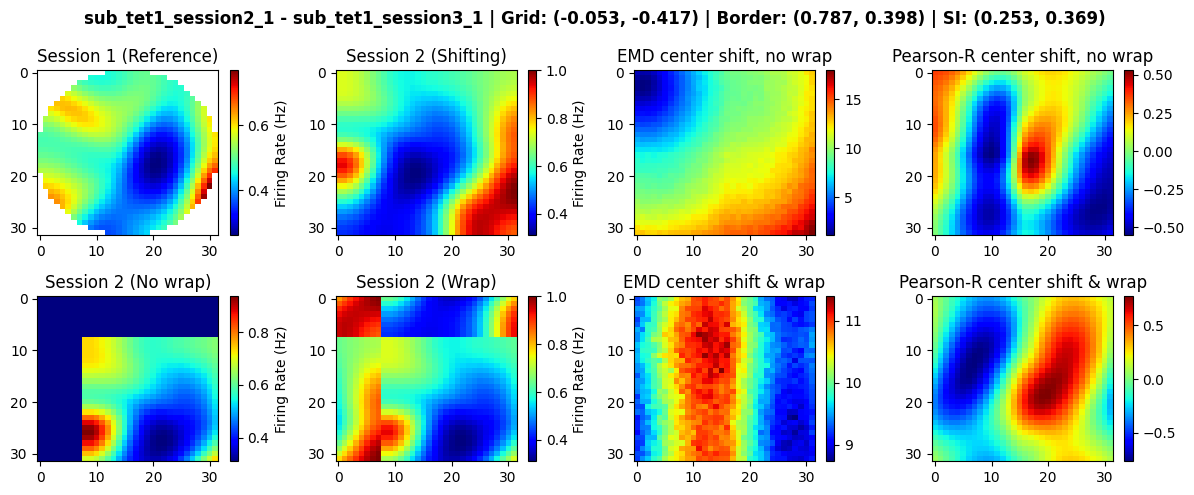

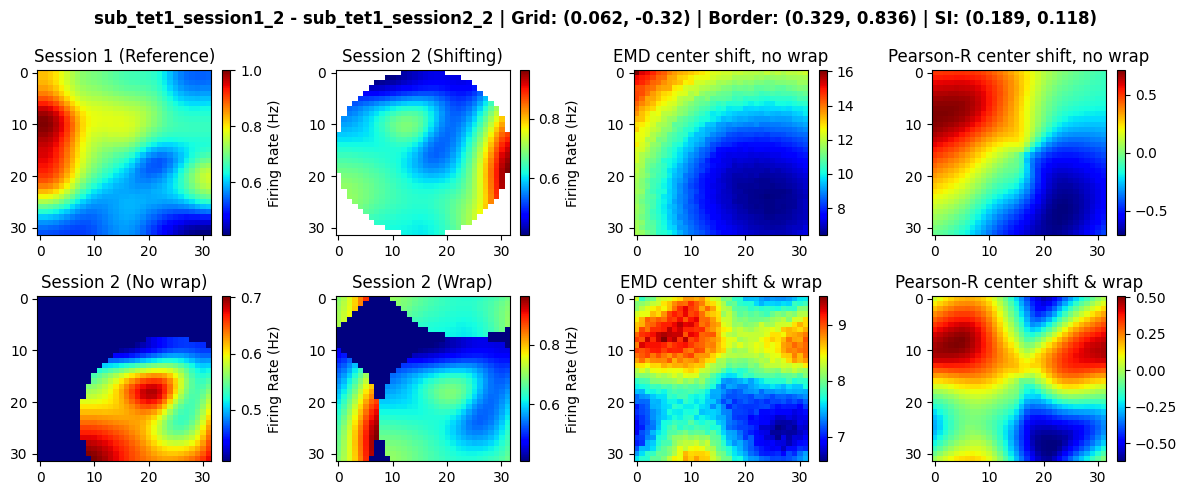

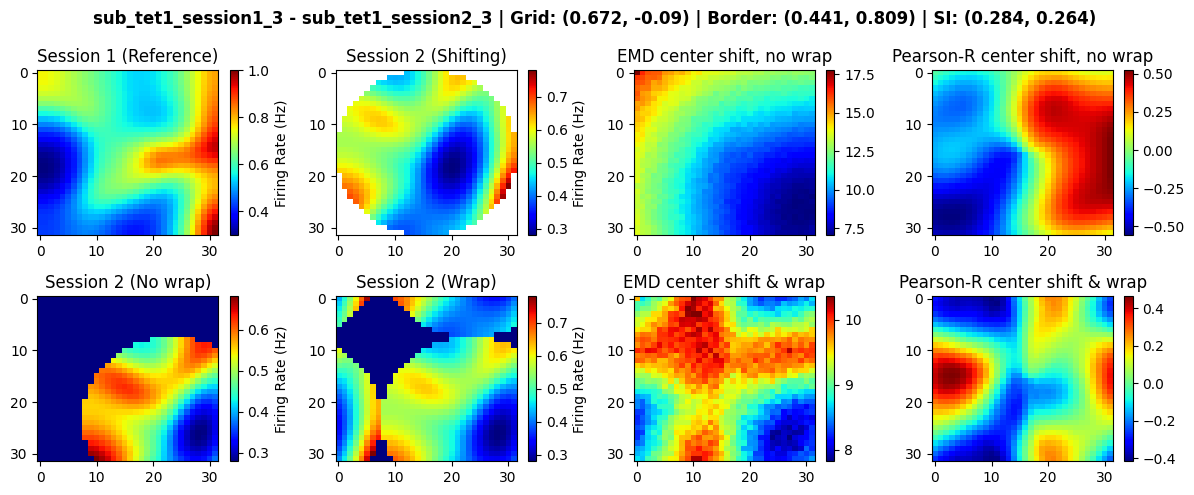

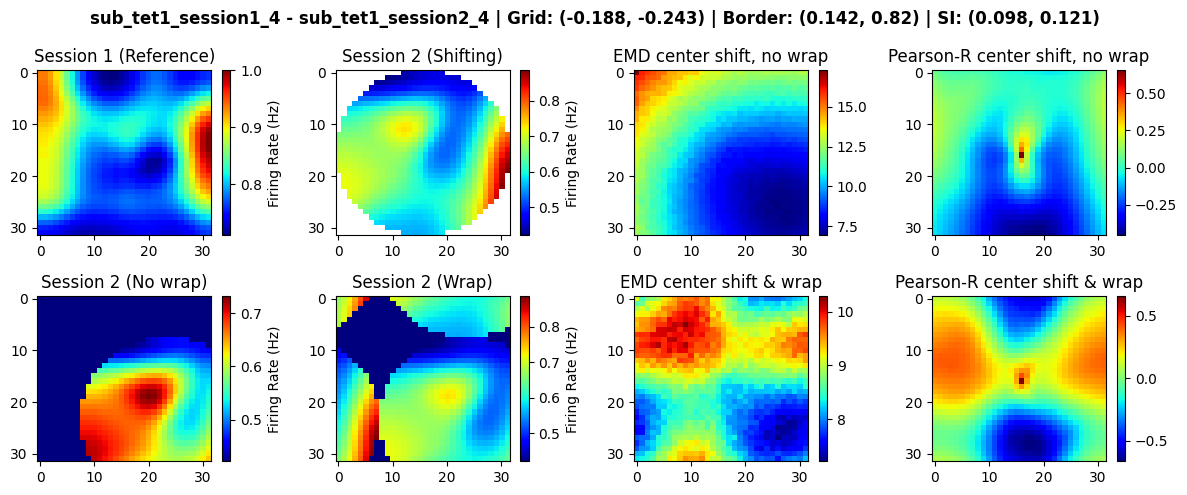

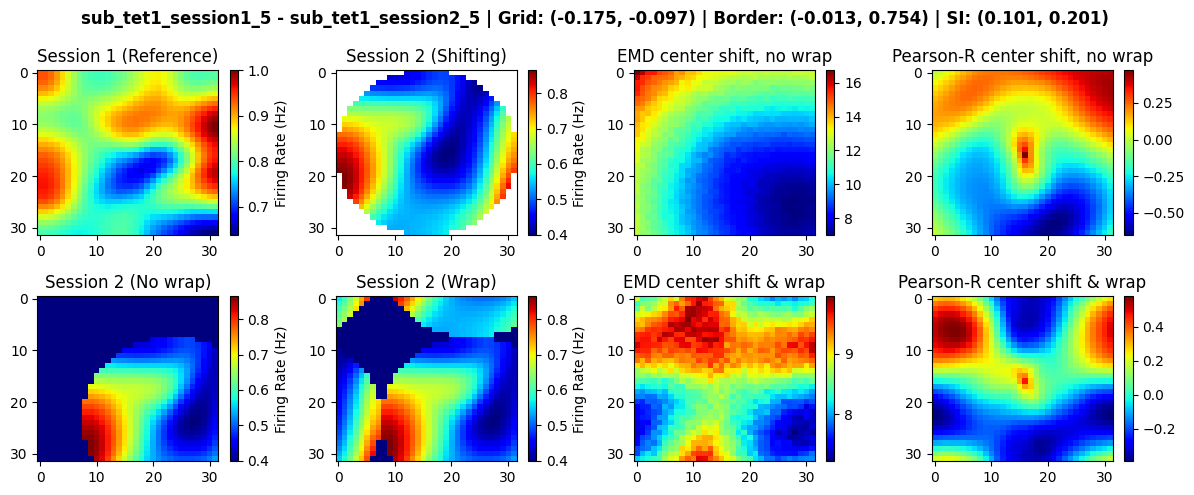

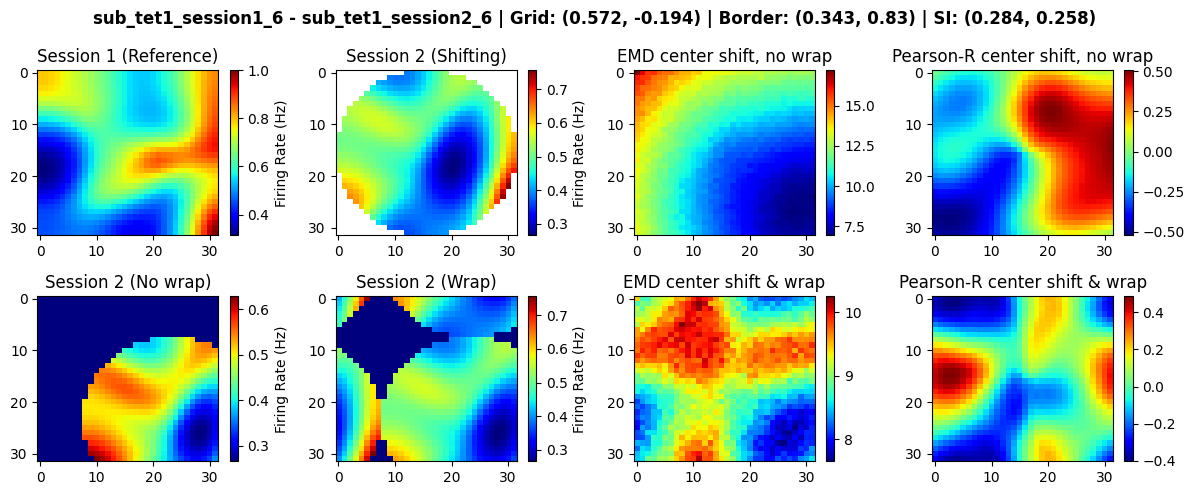

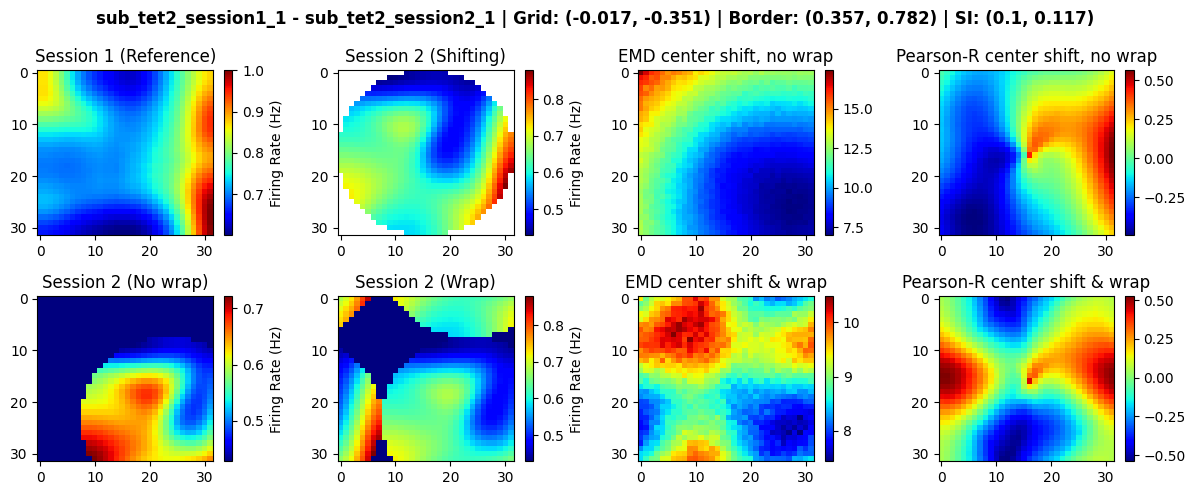

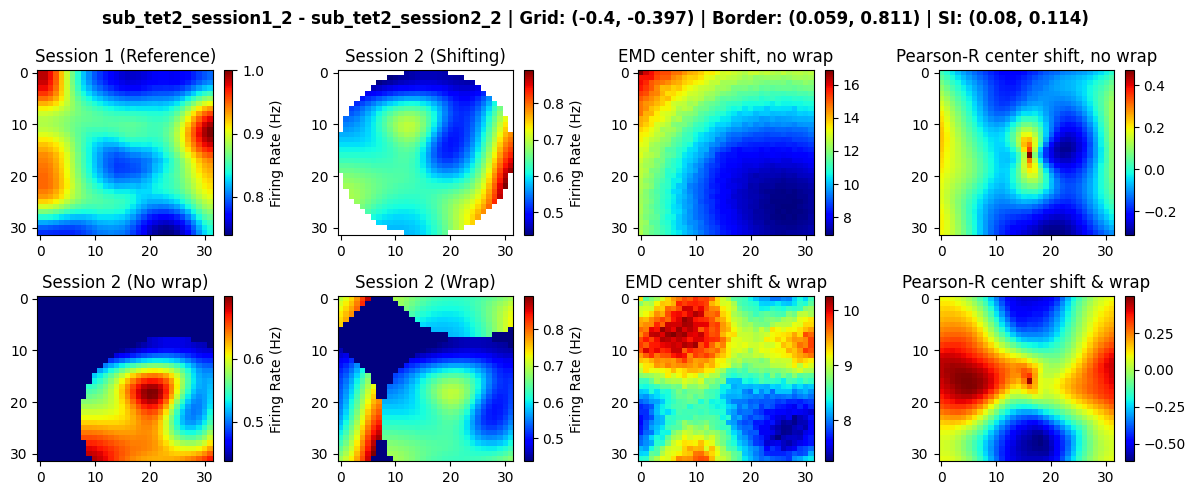

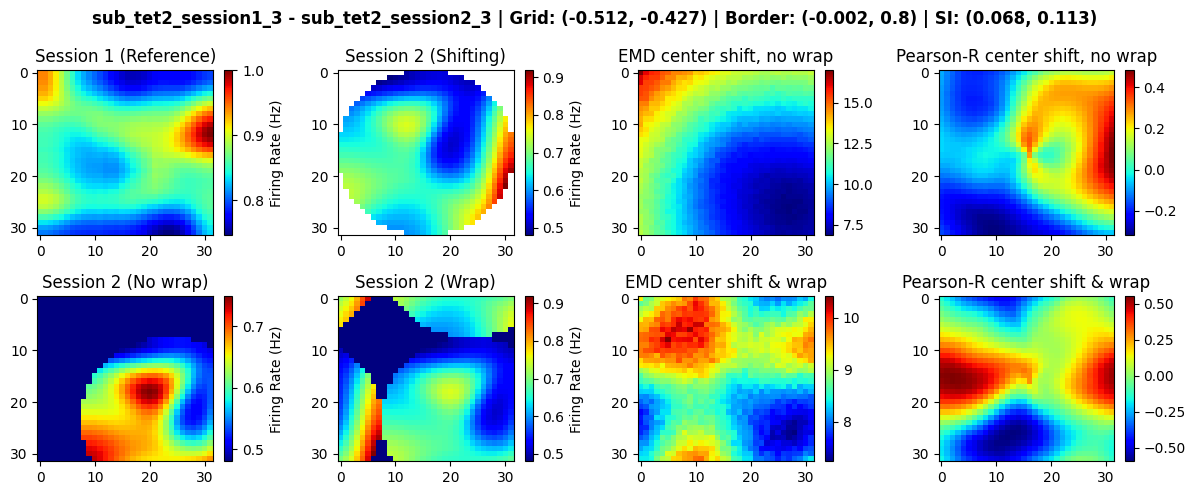

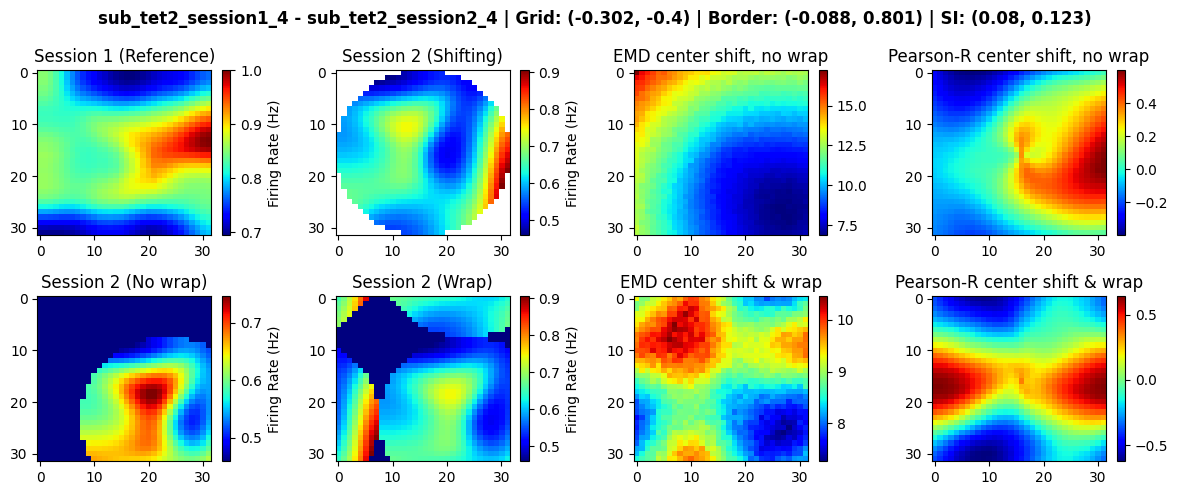

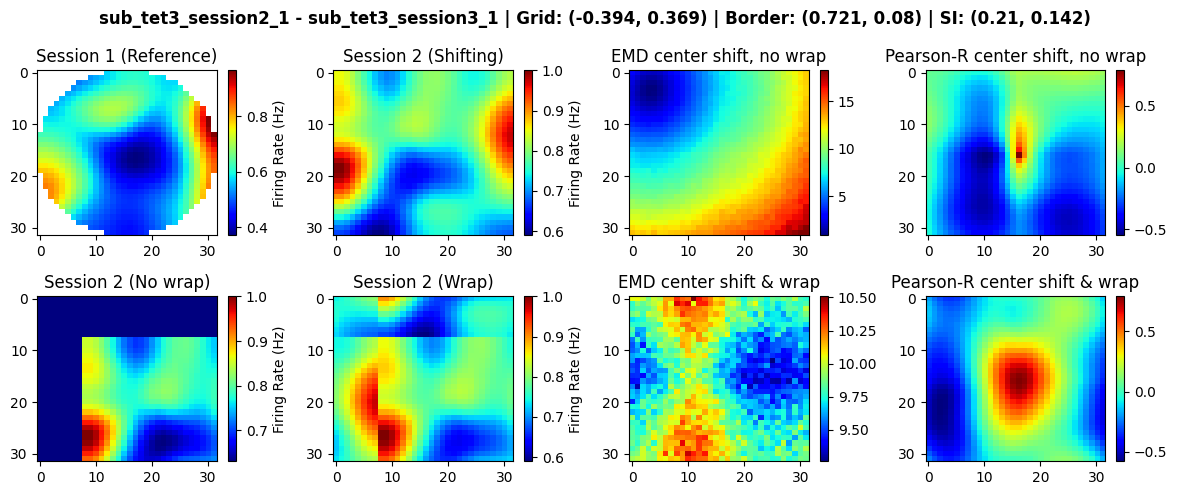

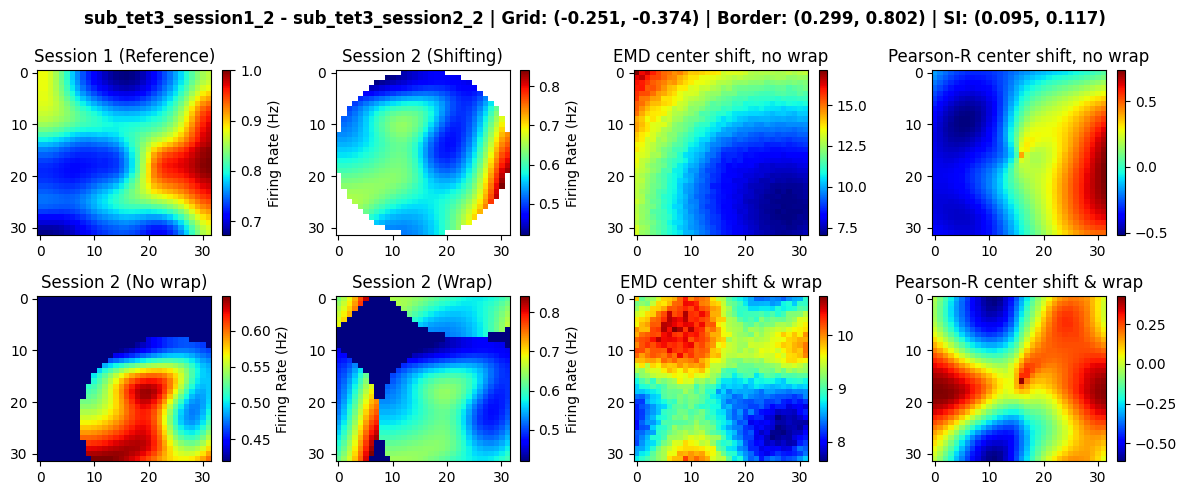

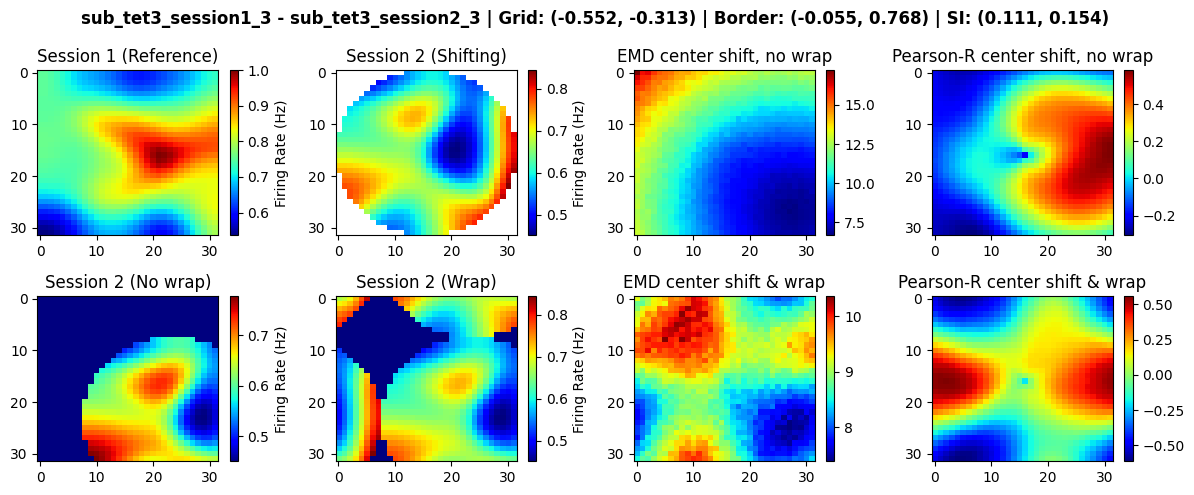

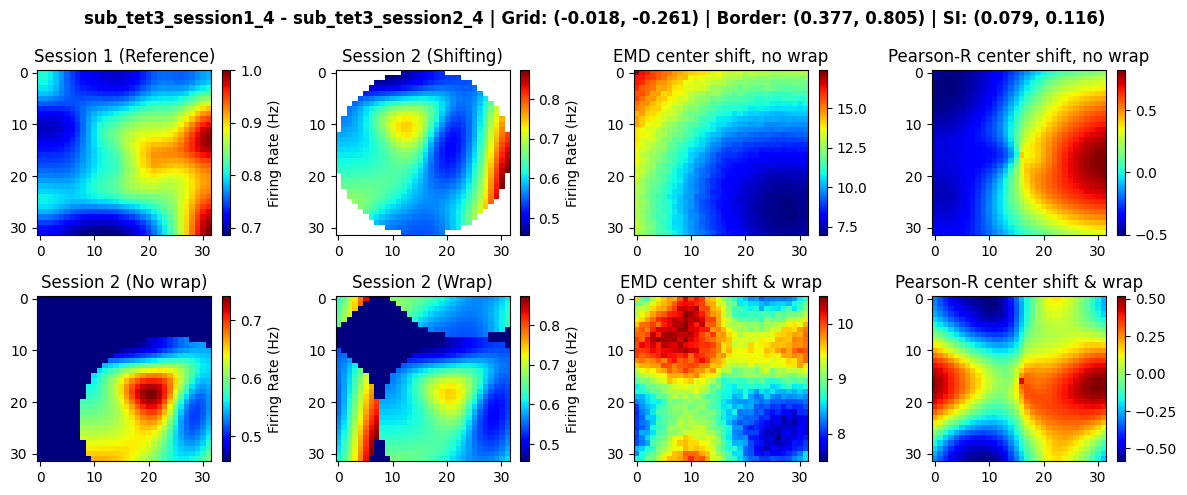

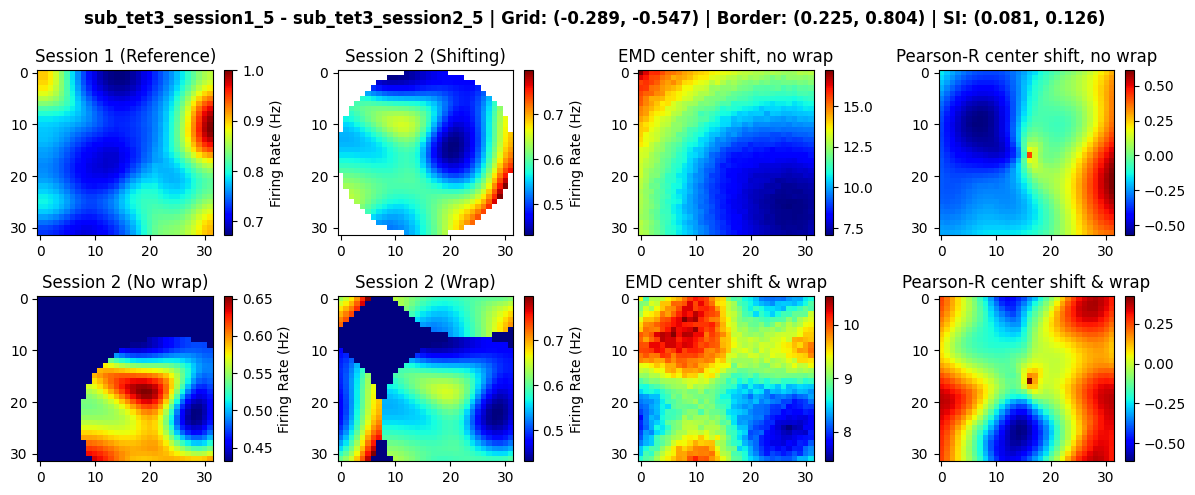

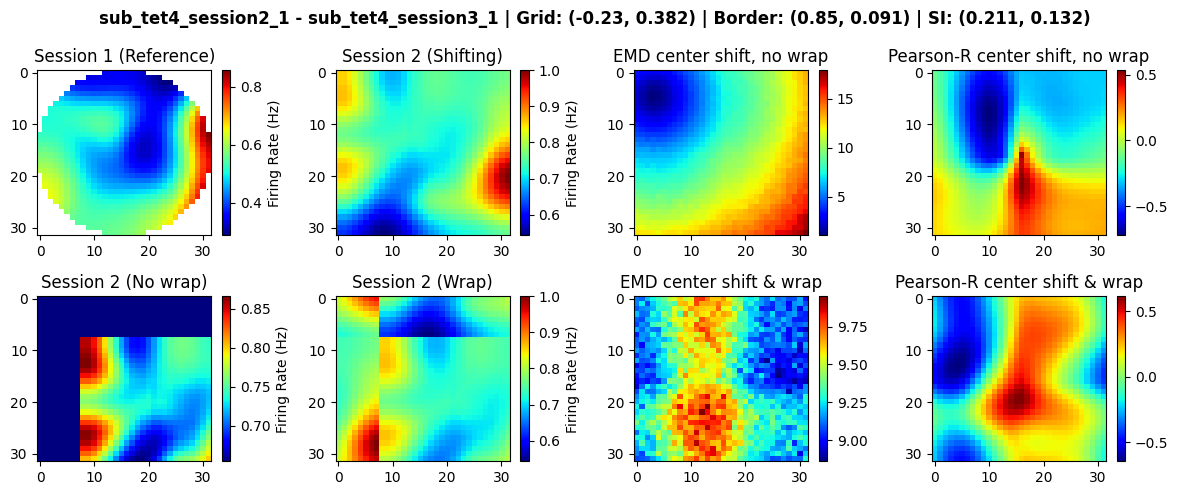

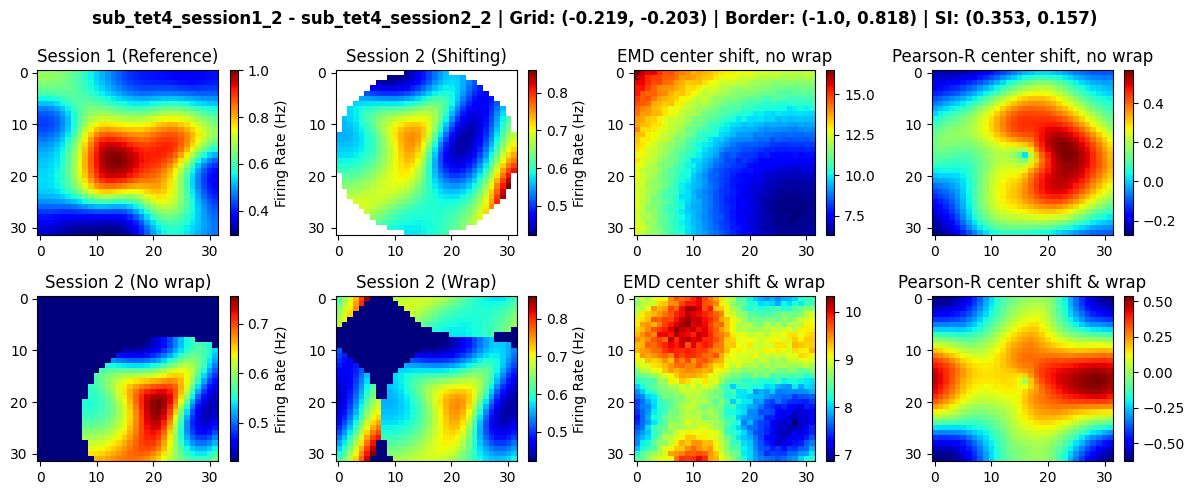

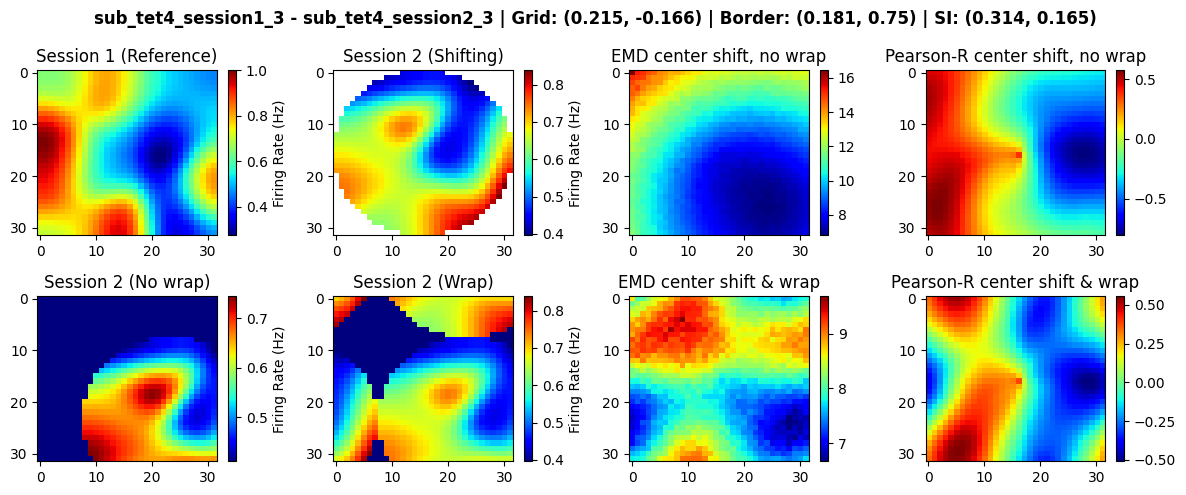

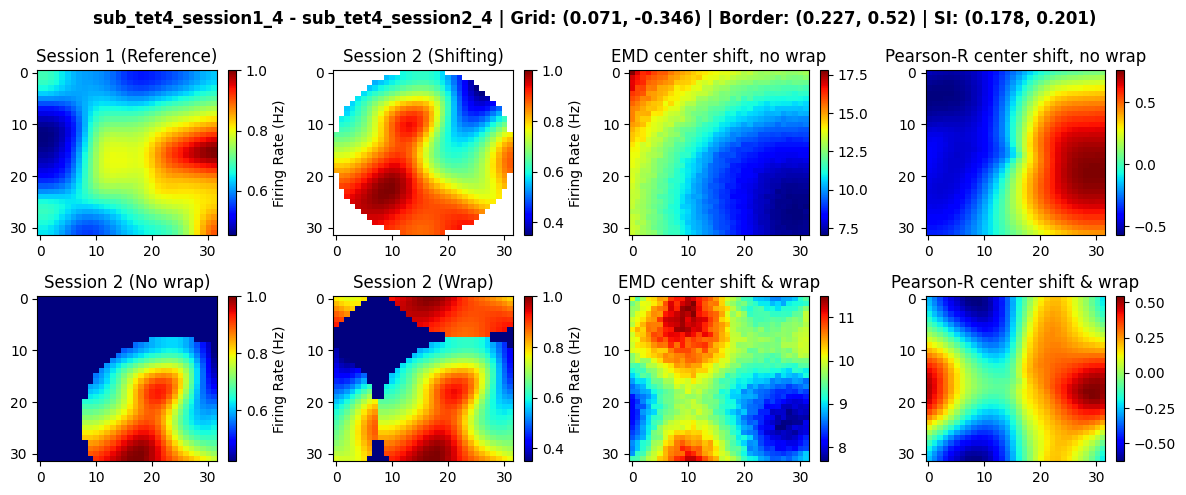

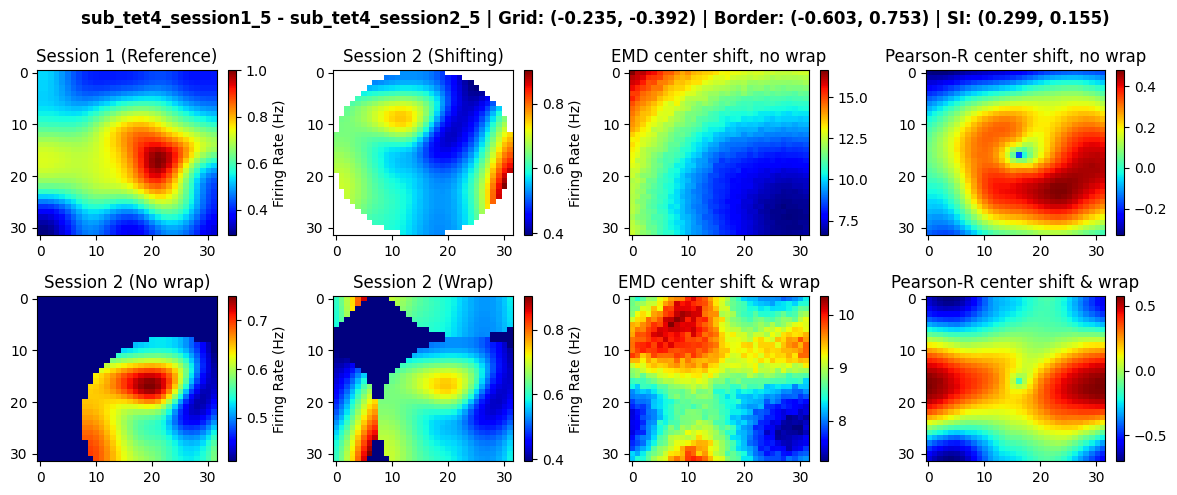

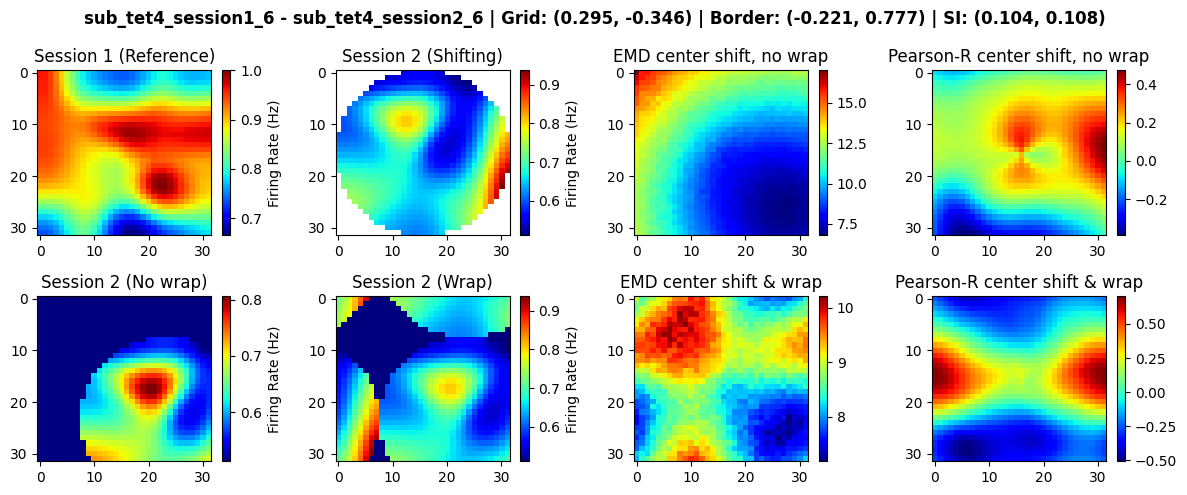

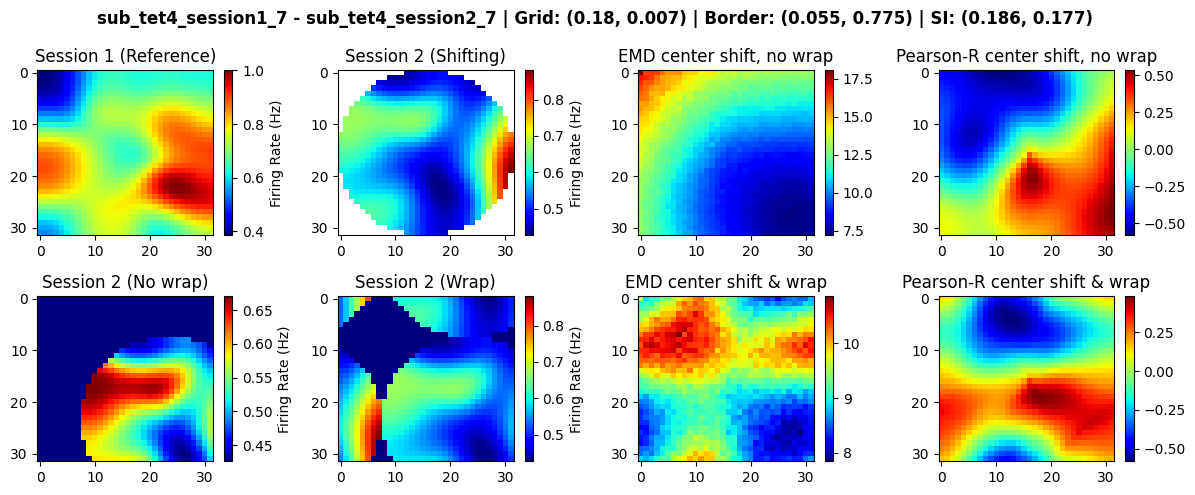

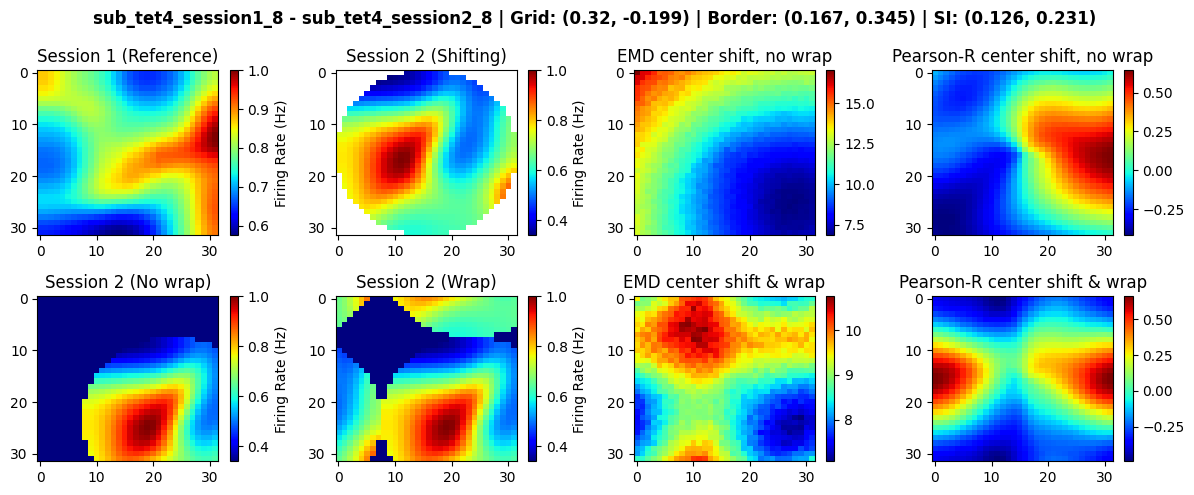

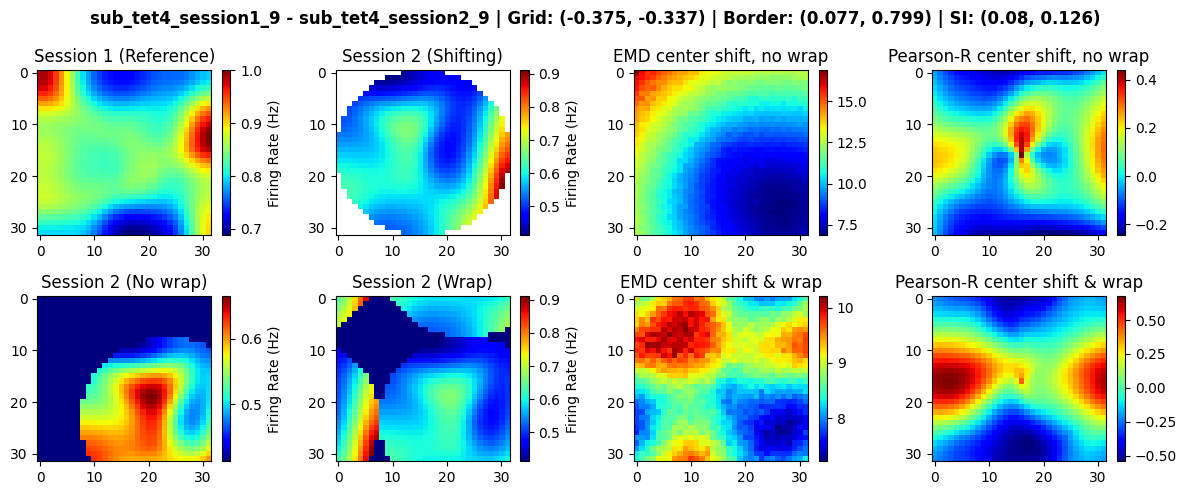

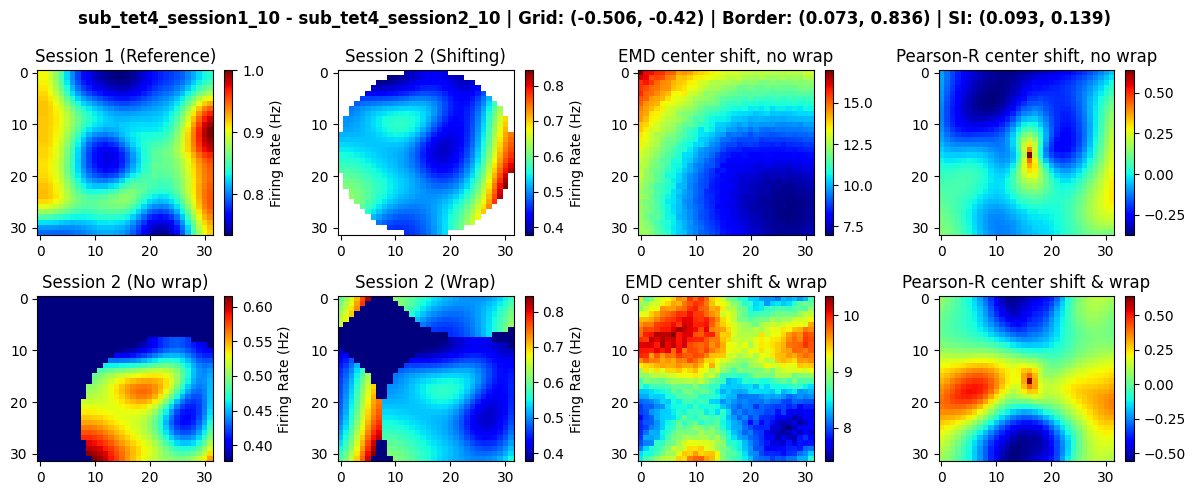

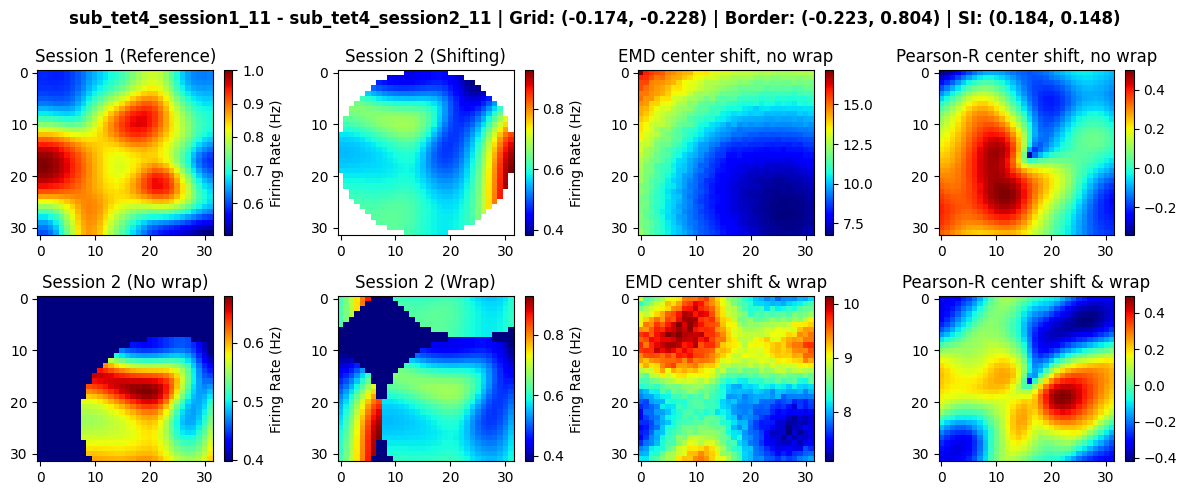

In [14]:
import scipy as sio

units = []
unit_keys = []
unit_titles = []
for ky in grouped_sessions.keys(): 
    uns = [cell_dict[x] for x in grouped_sessions[ky]]
    uns_keys = grouped_sessions[ky]
    pairs = []
    pair_keys = []
    pair_titles = []
    prev = None
    prev_key = None
    for i in range(len(uns)):
        if prev is not None:
            pairs.append([prev, uns[i]])
            pair_keys.append([prev_key, uns_keys[i]])
            pair_titles.append(prev_key + ' - ' + uns_keys[i])
        prev = uns[i]
        prev_key = uns_keys[i]

    units.append(pairs)
    unit_keys.append(pair_keys)
    unit_titles.append(pair_titles)


# c1u1ky = ['cell1_tet8_session1_1', 'cell1_tet8_session2_1']
# c1u2ky = ['cell1_tet8_session1_2', 'cell1_tet8_session2_2']
# c1u3ky = ['cell1_tet8_session1_3', 'cell1_tet8_session2_3']

# c2u1ky = ['cell2_tet4_session1_1', 'cell2_tet4_session2_1']
# c2u2ky = ['cell2_tet4_session1_2', 'cell2_tet4_session2_2']

# c1u1 = [cell_dict[x] for x in c1u1ky]
# c1u2 = [cell_dict[x] for x in c1u2ky]
# c1u3 = [cell_dict[x] for x in c1u3ky]

# c2u1 = [cell_dict[x] for x in c2u1ky]
# c2u2 = [cell_dict[x] for x in c2u2ky]

# units = [c1u1, c1u2, c1u3, c2u1, c2u2]
# unit_keys = [c1u1ky, c1u2ky, c1u3ky, c2u1ky, c2u2ky]
# unit_titles = ['MEC Tet 8 Unit 1', 'MEC Tet 8 Unit 2', 'MEC Tet 8 Unit 3', 'MEC Tet 4 Unit 1', 'MEC Tet 4 Unit 2']

for i in range(len(units)):
    unit = units[i][0]
    unit_title = unit_titles[i][0]
    wass, corr, wass_shifts, corr_shifts, wass_shifts_wrap, corr_shifts_wrap, wass_shifts_center, corr_shifts_center, wass_shifts_center_wrap, corr_shifts_center_wrap = scores_cell_dict[unit_keys[i][0][1]]
    prev_gscore, prev_bscore, prev_si_score = func_scores_dict[unit_keys[i][0][0]]
    curr_gscore, curr_bscore, curr_si_score = func_scores_dict[unit_keys[i][0][1]]

    # wass_shifts = flat_disk_mask(wass_shifts)
    # wass_shifts_wrap = flat_disk_mask(wass_shifts_wrap)
    # corr_shifts = flat_disk_mask(corr_shifts)
    # corr_shifts_wrap = flat_disk_mask(corr_shifts_wrap)
    # wass_shifts_center = flat_disk_mask(wass_shifts_center)
    # wass_shifts_center_wrap = flat_disk_mask(wass_shifts_center_wrap)
    # corr_shifts_center = flat_disk_mask(corr_shifts_center)
    # corr_shifts_center_wrap = flat_disk_mask(corr_shifts_center_wrap)

    fig = plt.figure(figsize=(12,5))

    toplot = unit[0]
    # toplot[toplot == 0] = np.nan

    ax = fig.add_subplot(2,4,1)
    img = ax.imshow(toplot, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    cbar.ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Session 1 (Reference)')

    # toplot = unit[1]
    # # toplot = flat_disk_mask(toplot)
    # toplot[toplot != toplot] = 0
    # toplot = sio.ndimage.shift(toplot, (8, 8), mode='constant', cval=0)
    # shifted_copy = np.copy(toplot)
    # toplot[toplot < 0.01] = np.nan
    
    toplot = unit[1]
    toplot_copy = np.copy(toplot)
    toplot_copy[toplot_copy != toplot_copy] = 0
    toplot_copy = sio.ndimage.shift(toplot_copy, (8, 8), mode='constant', cval=0)
    toplot_copy[toplot_copy < 0.01] = np.nan
    ax = fig.add_subplot(2,4,5)
    img = ax.imshow(toplot_copy, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    cbar.ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Session 2 (No wrap)')
    # shited_copy[shited_copy > 0.01] = np.nan
    # shifted_copy[shifted_copy == 0] = 0
    # ax.imshow(shifted_copy, cmap='jet', aspect='auto')
    not_nan = ~np.isnan(toplot_copy)
    is_nan = np.isnan(toplot_copy)
    toplot_copy[is_nan] = 0
    toplot_copy[not_nan] = np.nan
    ax.imshow(toplot_copy, cmap='jet', aspect='auto')

    toplot = unit[1]
    toplot[toplot == 0] = np.nan
    toplot = np.roll(toplot, shift=(8, 8), axis=(0, 1))
    ax = fig.add_subplot(2,4,6)
    img = ax.imshow(toplot, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    cbar.ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Session 2 (Wrap)')
    not_nan = ~np.isnan(toplot)
    is_nan = np.isnan(toplot)
    toplot[is_nan] = 0
    toplot[not_nan] = np.nan
    ax.imshow(toplot, cmap='jet', aspect='auto')

    ax = fig.add_subplot(2,4,2)
    to_plot = unit[1] 
    # to_plot[toplot == 0] = np.nan
    img = ax.imshow(to_plot, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    cbar.ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Session 2 (Shifting)')
    # stop()
    # ax = fig.add_subplot(2,6,3)
    # img = ax.imshow(wass_shifts, cmap='jet', aspect='auto')
    # cbar = fig.colorbar(img, ax=ax)
    # # cbar.ax.set_ylabel('')
    # ax.set_title('EMD corner shift, no wrap')

    ax = fig.add_subplot(2,4,3)
    img = ax.imshow(wass_shifts_center, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    # cbar.ax.set_ylabel('')
    ax.set_title('EMD center shift, no wrap')

    # ax = fig.add_subplot(2,6,4)
    # img = ax.imshow(corr_shifts, cmap='jet', aspect='auto')
    # cbar = fig.colorbar(img, ax=ax)
    # # cbar.ax.set_ylabel('Correlation')
    # ax.set_title('Pearson-R corner shift, no wrap')

    ax = fig.add_subplot(2,4,4)
    img = ax.imshow(corr_shifts_center, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    # cbar.ax.set_ylabel('Correlation')
    ax.set_title('Pearson-R center shift, no wrap')

    # ax = fig.add_subplot(2,6,5)
    # img = ax.imshow(wass_shifts_wrap, cmap='jet', aspect='auto')
    # cbar = fig.colorbar(img, ax=ax)
    # # cbar.ax.set_ylabel('')
    # ax.set_title('EMD corner shift & wrap')

    ax = fig.add_subplot(2,4,7)
    img = ax.imshow(wass_shifts_center_wrap, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    # cbar.ax.set_ylabel('')
    ax.set_title('EMD center shift & wrap')

    # ax = fig.add_subplot(2,4,7)
    # img = ax.imshow(corr_shifts_wrap, cmap='jet', aspect='auto')
    # cbar = fig.colorbar(img, ax=ax)
    # # cbar.ax.set_ylabel('Correlation')
    # ax.set_title('Pearson-R corner shift & wrap')

    ax = fig.add_subplot(2,4,8)
    img = ax.imshow(corr_shifts_center_wrap, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    # cbar.ax.set_ylabel('Correlation')
    ax.set_title('Pearson-R center shift & wrap')

    # unit_title
    ttle = 'LC Tet ' + unit_title.split('tet')[-1].split('_')[0] + ' Unit ' + unit_title.split('_')[-1]
    fig.suptitle(ttle + ' | Grid: (' + str(round(prev_gscore, 3)) + ', ' + str(round(curr_gscore, 3)) + 
                 ') | Border: (' + str(round(max(prev_bscore), 3)) + ', ' + str(round(max(curr_bscore), 3)) + 
                 ') | SI: (' + str(round(prev_si_score, 3)) + ', ' + str(round(curr_si_score, 3)) + ')',
                    fontsize=12, fontweight='bold')
    
    # fig.suptitle(unit_title + ' | Grid: ' + str(round(gscore, 3)) + ' | Border: ' + str(round(max(bscore), 3)) + ' | SI: ' + str(round(si_score, 3)))
    #' | Wass: ' + str(round(wass, 3)) + ' | Corr: ' + str(round(corr, 3)) + 
    fig.tight_layout()
    plt.show()



In [ ]:
fname

In [ ]:
plt.imshow(wass_shifts, cmap='jet')

In [ ]:
unit[0][0]